# AnTeDe Lab 2: Text Classification - Part B

## Session goal
The goal of this session is to implement a Multinomial Naive Bayes classifier with standard building blocks from *scikit-learn*. 

## Data collection
The dataset is the same as in Lab 2a.

In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


training_corpus=["The Limmat flows out of the lake.", 
                 "The bears are in the bear pit near the river.",
                 "The Rhône flows out of Lake Geneva.",]
training_labels=["zurich", 
                 "bern",
                 "geneva",]

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We extract the features with CountVectorizer, removing the stop words automatically.

Something goes wrong. What is it?

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

# utility function
def visualize(column_names, columns, row_names=None):
    df=pd.DataFrame(columns=column_names)

    for index, feature in enumerate(column_names):
        df[feature]=columns[:,index]
        
    if row_names is not None:
        for index, row_label in enumerate(row_names):
            df=df.rename({index:row_label}, axis='index')
            
    return df

vectorizer = CountVectorizer(stop_words='english')
features = vectorizer.fit_transform(training_corpus)  

df = visualize(column_names=vectorizer.get_feature_names(), \
               columns=features.toarray(), \
               row_names = training_corpus)

print (df.to_string())

                                               bear  bears  flows  geneva  lake  limmat  near  pit  rhône  river
The Limmat flows out of the lake.                 0      0      1       0     1       1     0    0      0      0
The bears are in the bear pit near the river.     1      1      0       0     0       0     1    1      0      1
The Rhône flows out of Lake Geneva.               0      0      1       1     1       0     0    0      1      0


What went wrong is that we failed to lemmatize our tokens. For purposes of text classification, the tokens 'bear' and 'bears' carry the same information. Study the code below to see how you can add a lemmatizer to CountVectorizer.

In [3]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)\
             if (t.isalnum())]

vectorizer = CountVectorizer(stop_words='english', tokenizer=LemmaTokenizer())
bow_training_features = vectorizer.fit_transform(training_corpus)  

df = visualize(column_names=vectorizer.get_feature_names(), \
               columns=bow_training_features.toarray(), \
               row_names = training_corpus)
print (df.to_string())

                                               bear  flow  geneva  lake  limmat  near  pit  rhône  river
The Limmat flows out of the lake.                 0     1       0     1       1     0    0      0      0
The bears are in the bear pit near the river.     2     0       0     0       0     1    1      0      1
The Rhône flows out of Lake Geneva.               0     1       1     1       0     0    0      1      0


/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Write the code to extract and visualize the test features based on the test corpus below.

In [4]:
test_corpus = ['We saw the bears there.', 
               'We crossed the Rhône.', 
               'There is no lake.',]
test_labels = ['bern',
               'geneva',
               'bern',]

# BEGIN_REMOVE
bow_test_features = vectorizer.transform(test_corpus) 

df = visualize(column_names=vectorizer.get_feature_names(), \
               columns=bow_test_features.toarray(), \
               row_names = test_corpus)

print (df.to_string())
# END_REMOVE

                         bear  flow  geneva  lake  limmat  near  pit  rhône  river
We saw the bears there.     1     0       0     0       0     0    0      0      0
We crossed the Rhône.       0     0       0     0       0     0    0      1      0
There is no lake.           0     0       0     1       0     0    0      0      0


With the following code, we fit a classifier to the training data, run it on the test data, and evaluate its performance.

In [5]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report


def show_overview(test_corpus, test_labels, predicted_labels):
    df=pd.DataFrame()
    df['test_corpus']=test_corpus
    df['test_labels']=test_labels
    df['predicted_labels']=predicted_labels
    
    print (df.to_string())

        
def run_model(classifier, training_data, training_labels, test_data, test_labels):
    # build model
    classifier.fit(training_data, training_labels)
    # predict using model
    predictions = classifier.predict(test_data)
    # evaluate model prediction performance
    get_metrics(true_labels=test_labels, predicted_labels=predictions)
    
    return list(predictions)
    

def get_metrics(true_labels, predicted_labels):
    print ('Accuracy:', np.round(
        metrics.accuracy_score(true_labels,
        predicted_labels), 3))
    print(classification_report(true_labels, predicted_labels))  

In [6]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

predicted_labels = run_model(classifier=mnb,
                             training_data=bow_training_features,
                             training_labels=training_labels, 
                             test_data=bow_test_features, 
                             test_labels=test_labels)

show_overview(test_corpus, test_labels, predicted_labels) 

Accuracy: 0.667
              precision    recall  f1-score   support

        bern       1.00      0.50      0.67         2
      geneva       1.00      1.00      1.00         1
      zurich       0.00      0.00      0.00         0

    accuracy                           0.67         3
   macro avg       0.67      0.50      0.56         3
weighted avg       1.00      0.67      0.78         3

               test_corpus test_labels predicted_labels
0  We saw the bears there.        bern             bern
1    We crossed the Rhône.      geneva           geneva
2        There is no lake.        bern           zurich


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The following cell contains a function that shows a pretty version of the confusion matrix we just printed out.

               test_corpus test_labels predicted_labels
0  We saw the bears there.        bern             bern
1    We crossed the Rhône.      geneva           geneva
2        There is no lake.        bern           zurich


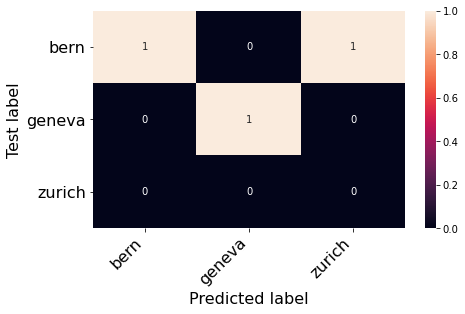

In [7]:
def pretty_confusion_matrix(true_labels, predicted_labels, target_names, base=7, height=4):

    # Based on original work by Shay Palachy
    # Original code at https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    
    import matplotlib.pyplot as plt
    import seaborn as sea
    import numpy as np
    figsize = (base, height)
    fontsize=16
    fig = plt.figure(figsize=figsize)
   
    
    from sklearn.metrics import confusion_matrix
    
    
    try:
        heatmap = sea.heatmap(confusion_matrix(true_labels, predicted_labels),\
                                  annot=True, fmt="d")
        if target_names is not None:
            tick_marks = np.arange(len(target_names))+0.5
            plt.xticks(tick_marks, target_names, rotation=45)
            plt.yticks(tick_marks, target_names)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Test label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    
    
def show_overview(test_corpus, test_labels, predicted_labels):
    df=pd.DataFrame()
    df['test_corpus']=test_corpus
    df['test_labels']=test_labels
    df['predicted_labels']=predicted_labels
    print (df.to_string())

target_names = sorted(list(set(training_labels)))
    
show_overview(test_corpus, test_labels, predicted_labels) 
pretty_confusion_matrix(test_labels, predicted_labels, target_names)


Pipelines provide a much faster way to deploy a classifier. See below how we use a pipeline to build the same classifier we just built, only much faster.

Accuracy: 0.667
              precision    recall  f1-score   support

        bern       1.00      0.50      0.67         2
      geneva       1.00      1.00      1.00         1
      zurich       0.00      0.00      0.00         0

    accuracy                           0.67         3
   macro avg       0.67      0.50      0.56         3
weighted avg       1.00      0.67      0.78         3



/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


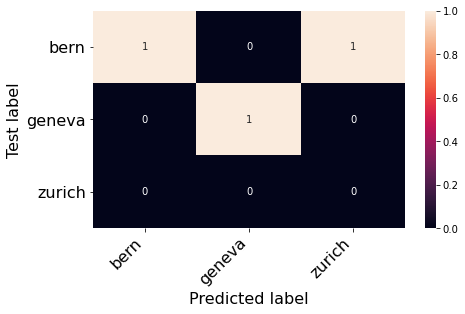

In [8]:
from sklearn.pipeline import Pipeline

mnb_pipeline = Pipeline(
    [('vectorizer', CountVectorizer(stop_words='english', tokenizer=LemmaTokenizer())),
     ('classifier', MultinomialNB())])

mnb_pipeline.fit(training_corpus, training_labels) 
predicted_labels = mnb_pipeline.predict(test_corpus)
get_metrics(true_labels=test_labels, predicted_labels=predicted_labels)

pretty_confusion_matrix(test_labels, predicted_labels, target_names)

The following cell contains a simple example of how Term Frequency Inverse Document Frequency (TF-IDF) feature extraction works. Tokens that are common across documents get a lower weight because we assume they aren't very informative. Tokens that are common within individual documents get a higher weight because we assume they can be very helpful in classifying a document.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
documents=["Bern is the capital of the Canton of Bern.", 
           "Zurich is the capital of the Canton of Zurich."]
 
vectorizer=TfidfVectorizer(stop_words='english')
features=vectorizer.fit_transform(documents)

In this example, *Bern* and *Zurich* get much higher weights than *canton* and *capital*. Why?

In [10]:
df = visualize(column_names=vectorizer.get_feature_names(),
               columns=features.toarray(),
               row_names = documents)

print (df)

                                                    bern  canton  capital  \
Bern is the capital of the Canton of Bern.      0.893312  0.3178   0.3178   
Zurich is the capital of the Canton of Zurich.  0.000000  0.3178   0.3178   

                                                  zurich  
Bern is the capital of the Canton of Bern.      0.000000  
Zurich is the capital of the Canton of Zurich.  0.893312  


Let's do a slightly better job of training our classifier by augmenting our training set with more data. 

Add the following datasets to our existing training data.

In [11]:
documents_zh_be = ["It's one of Europe's smallest capital cities.", 
                 "It is home to the Swiss Stock Exchange.",
                 "It is home to the Swiss National Bank.", 
                 "Google is near Bahnhof Enge.",
                 "It is home to the Federal Council.", 
                 "It is home to the National Council.",
                 "The lake is certainly one of the city's highlights.",
                 "Bern is also the capital of the canton of Bern.",
                 "Zurich is also the capital of the canton of Zurich."]
classes_zh_be = ["bern", 
               "zurich",
               "bern", 
               "zurich",
               "bern", 
               "bern",
               "zurich",
               "bern",
               "zurich"]

documents_ge = ["The Rhône flows right through it and into the lake.",
              "We saw Lake Léman from Quai du Mont Blanc.",
              "I hear they speak French there.", 
              "It was annexed by France in 1798.",
              "It joined the Swiss Confederation in 1815.", 
              "It is home to CERN."]
classes_ge = ['geneva' for x in documents_ge]

test_documents_zh = ['It is the city of Zwingli']
test_label_zh = ['zurich']

# BEGIN_REMOVE
training_corpus=[*training_corpus, *documents_zh_be, *documents_ge]
training_labels=[*training_labels, *classes_zh_be, *classes_ge]
test_corpus = [*test_corpus, *test_documents_zh]
test_labels = [*test_labels, *test_label_zh]
# END_REMOVE

__YOUR ASSIGNMENT__

- Train a classifier with our extended training data
- Evaluate its performance using all standard metrics
- Print out the confusion matrix
- Examine the test documents that got misclassified
- Can you explain what is happening? Have we improved the classifier? Why or why not?

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5
              precision    recall  f1-score   support

        bern       0.50      0.50      0.50         2
      geneva       0.50      1.00      0.67         1
      zurich       0.00      0.00      0.00         1

    accuracy                           0.50         4
   macro avg       0.33      0.50      0.39         4
weighted avg       0.38      0.50      0.42         4

                 test_corpus test_labels predicted_labels
0    We saw the bears there.        bern             bern
1      We crossed the Rhône.      geneva           geneva
2          There is no lake.        bern           geneva
3  It is the city of Zwingli      zurich             bern


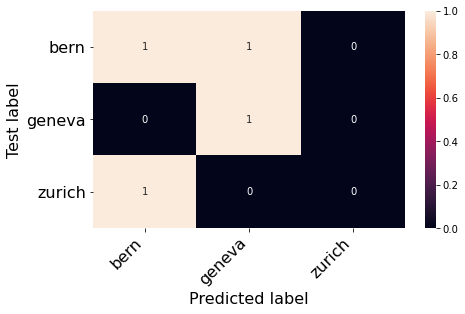

In [12]:
# BEGIN_REMOVE
mnb_pipeline = Pipeline([ 
    ('vectorizer', CountVectorizer(stop_words='english', tokenizer=LemmaTokenizer())),
    ('classifier', MultinomialNB())])

mnb_pipeline.fit(training_corpus, training_labels) 
predicted_labels = mnb_pipeline.predict(test_corpus)
get_metrics(true_labels=test_labels,predicted_labels=predicted_labels)

show_overview(test_corpus, test_labels, predicted_labels) 
pretty_confusion_matrix(test_labels, predicted_labels, target_names)
# END_REMOVE

Follow-up task: add one more training document that will help you get rid of the UndefinedMetricWarning

Accuracy: 0.75
              precision    recall  f1-score   support

        bern       1.00      0.50      0.67         2
      geneva       0.50      1.00      0.67         1
      zurich       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.83      0.83      0.78         4
weighted avg       0.88      0.75      0.75         4

                 test_corpus test_labels predicted_labels
0    We saw the bears there.        bern             bern
1      We crossed the Rhône.      geneva           geneva
2          There is no lake.        bern           geneva
3  It is the city of Zwingli      zurich           zurich


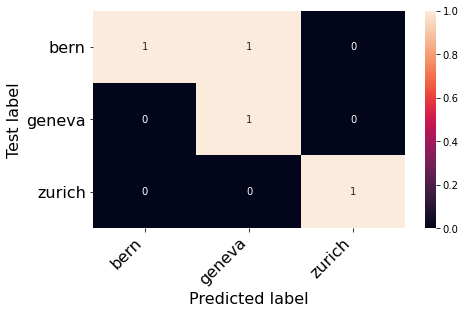

In [13]:
# BEGIN_REMOVE
training_corpus.append('I like Zurich.')
training_labels.append('zurich')
mnb_pipeline.fit(training_corpus, training_labels) 
predicted_labels = mnb_pipeline.predict(test_corpus)
get_metrics(true_labels=test_labels,
        predicted_labels=predicted_labels)

show_overview(test_corpus, test_labels, predicted_labels) 
pretty_confusion_matrix(test_labels, predicted_labels, target_names)
# END_REMOVE

Bonus question: how was the MNB able to classify *It is the city of Zwingli.*, given that *Zwingli* doesn't appear in the training data?